In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
from pathlib import Path

In [2]:
path = Path(r"C:\Users\mkcoo\Documents\UW\GitHub\PNSB\PettRidge\rpal.xml")
model = read_sbml_model(str(path.resolve()))

mdetails = pd.read_excel(r'C:\Users\mkcoo\Documents\UW\GitHub\PNSB\PettRidge\modelDetails.xlsx', sheet_name='Reactions')

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C00234 "10-Formyltetrahydrofolate">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C15606 "1,2-dihydroxy-3-keto-5-methylthiopentene">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C00641DA "1,2-Diacyl-sn-glycerol (Dark Aerobic)">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C00641LN "1,2-Diacyl-sn-glycerol (Light Anaerobic)">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C04092 "1,2-Didehydropiperidine-2-carboxylate">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C05758 "trans-Dodec-2-enoyl-[acp]">
Use of the spec

## Setting relevant bounds and uptake rate(s)

In [3]:
# Setting acetate uptake rate to 0
model.reactions.XR57.bounds = (0, 0) # acetate

# CO2 import/export bounds
model.reactions.XR72.bounds = (0, 0)
model.reactions.XR73.bounds = (0, 1000)

# Permitting metabolite efflux for acetate
model.reactions.XR59.bounds = (0, 100)

# Introducing FdxOR KO
model.reactions.R01195.bounds = (0, 0)

## Baseline

In [4]:
# Define uptake ranges
cou_rates = np.linspace(0.1, 1.5, 50)

# Initialize results
cou_dtimes = []
cou_cfixes = []

# Collect simulation results
for i, cou_rate in enumerate(cou_rates):
    model.reactions.XR242.bounds = (cou_rate, cou_rate)
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        cou_dtimes.append(mu*24)
        cou_stand_df = solution.to_frame()
        cou_cfixes.append(cou_stand_df.loc['R00024'].fluxes)

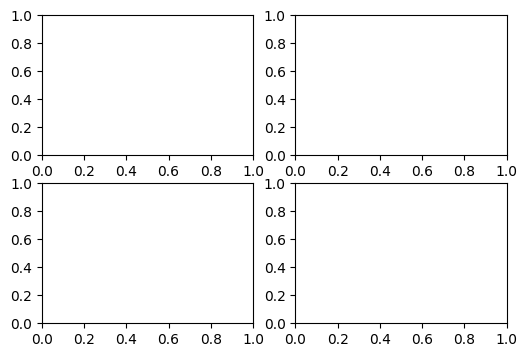

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4)) # 1 row, 3 columns

## Xylose

In [6]:
new_met = Metabolite(
    id="C00181",
    name="C00181",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="C00379",
    name="C00379",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_rxn = Reaction("R01431")
new_rxn.name = "R01431"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

xylose = model.metabolites.get_by_id("C00181")
xylitol = model.metabolites.get_by_id("C00379")
nadph = model.metabolites.get_by_id("C00005")
nadp = model.metabolites.get_by_id("C00006")
h = model.metabolites.get_by_id("C00080")

new_rxn.add_metabolites({
    xylose: -1.0,
    nadph: -1.0,
    h: -1.0,
    xylitol: 1.0,
    nadp: 1.0
})

model.add_reactions([new_rxn])

In [7]:
new_met = Metabolite(
    id="C00379XT",
    name="C00379XT",
    compartment="XT"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="C00379PX",
    name="C00379PX",
    compartment="PX"
)
model.add_metabolites([new_met])

new_rxn = Reaction("xylitolExport")
new_rxn.name = "xylitolExport"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

xylitolext = model.metabolites.get_by_id("C00379XT")

new_rxn.add_metabolites({
    xylitolext: -1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("xylitolMembraneExchange")
new_rxn.name = "xylitolMembraneExchange"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

xylitolext = model.metabolites.get_by_id("C00379XT")
xylitolpx = model.metabolites.get_by_id("C00379PX")

new_rxn.add_metabolites({
    xylitolext: -1.0,
    xylitolpx: 1.0
})

model.add_reactions([new_rxn])

new_rxn = Reaction("xylitolExchange")
new_rxn.name = "xylitolExchange"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

xylitolpx = model.metabolites.get_by_id("C00379PX")
xylitol = model.metabolites.get_by_id("C00379")

new_rxn.add_metabolites({
    xylitolpx: -1.0,
    xylitol: 1.0
})

model.add_reactions([new_rxn])

In [8]:
new_met = Metabolite(
    id="C00181XT",
    name="C00181XT",
    compartment="XT"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="C00181PX",
    name="C00181PX",
    compartment="PX"
)
model.add_metabolites([new_met])

new_rxn = Reaction("xyloseImport")
new_rxn.name = "xyloseImport"
new_rxn.lower_bound = 0
new_rxn.upper_bound = 1000

xyloseext = model.metabolites.get_by_id("C00181XT")

new_rxn.add_metabolites({
    xyloseext: 1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("xyloseExport")
new_rxn.name = "xyloseExport"
new_rxn.lower_bound = 0
new_rxn.upper_bound = 1000

xyloseext = model.metabolites.get_by_id("C00181XT")

new_rxn.add_metabolites({
    xyloseext: -1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("xyloseMembraneExchange")
new_rxn.name = "xyloseMembraneExchange"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

xyloseext = model.metabolites.get_by_id("C00181XT")
xylosepx = model.metabolites.get_by_id("C00181PX")

new_rxn.add_metabolites({
    xyloseext: -1.0,
    xylosepx: 1.0
})

model.add_reactions([new_rxn])

new_rxn = Reaction("xyloseExchange")
new_rxn.name = "xyloseExchange"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

xylosepx = model.metabolites.get_by_id("C00181PX")
xylose = model.metabolites.get_by_id("C00181")

new_rxn.add_metabolites({
    xylosepx: -1.0,
    xylose: 1.0
})

model.add_reactions([new_rxn])

In [9]:
model.reactions.xyloseImport.bounds = (0.5, 0.5)

In [10]:
# Initialize results
xyl_dtimes = []
xyl_cfixes = []
xylitol = []

# Collect simulation results
for i, cou_rate in enumerate(cou_rates):
    model.reactions.XR242.bounds = (cou_rate, cou_rate)
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        xyl_dtimes.append(mu*24)
        xyl_stand_df = solution.to_frame()
        xyl_cfixes.append(xyl_stand_df.loc['R00024'].fluxes)
        xylitol.append(xyl_stand_df.loc['xylitolExport'].fluxes)

In [11]:
# Plot doubling time on left y-axis
color1 = 'lightsteelblue'
color2 = 'royalblue'

axs[0,0].set_xlabel('p-Coumarate Uptake Rate (mmol/gDW/hr)')
axs[0,0].set_ylabel('Growth Rate (1/day)', color=color2)
j1 = axs[0,0].plot(cou_rates, cou_dtimes, label='Growth (WT^FdxOR)', color=color1)
j2 = axs[0,0].plot(cou_rates, xyl_dtimes, label='Growth (*Xyl^FdxOR)', color=color2)
axs[0,0].tick_params(axis='y', labelcolor=color2)

# Create a second y-axis sharing the same x-axis
ax20 = axs[0,0].twinx()

# Plot carbon and nitrogen fixation on right y-axis
color3 = 'lightgreen'
color4 = 'seagreen'
color5 = 'firebrick'


j3 = ax20.plot(cou_rates, cou_cfixes, label='Carbon Fixation (WT^FdxOR)', color=color3)
j4 = ax20.plot(cou_rates, xyl_cfixes, label='Carbon Fixation (*Xyl^FdxOR)', color=color4)
j5 = ax20.plot(cou_rates, xylitol, label='Xylitol Production', color=color5)

ax20.set_ylabel('')
ax20.set_yticklabels([])
ax20.tick_params(right=True)  # ensures tick marks still draw

handles = j1 + j2 + j3 + j4 + j5
labels = [h.get_label() for h in handles]

axs[0,0].legend(handles, labels, bbox_to_anchor=(0.2, 0.6), loc='upper left',fontsize=6)

axs[0,0].set_title('Xylose Pathway')

Text(0.5, 1.0, 'Xylose Pathway')

## Resetting model

In [12]:
model.remove_reactions(["R01431", "xylitolExport", "xylitolMembraneExchange",
                        "xylitolExchange", "xyloseImport", "xyloseExport",
                        "xyloseMembraneExchange", "xyloseExchange"
                        ])


## 4EP Pathway

In [13]:
new_met = Metabolite(
    id="C05627",
    name="4VP",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="C13637",
    name="ethylPhenol",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

## Add the necessary reactions
# Reaction PAD catalyzing conversion of coumarate to 4VP

new_rxn = Reaction("R02952")
new_rxn.name = "Phenylacrylic acid decarboxylase"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

fourvp = model.metabolites.get_by_id("C05627")
co2 = model.metabolites.get_by_id("C00011")
coumarate = model.metabolites.get_by_id("C00811")

new_rxn.add_metabolites({
    fourvp: 1.0,
    co2: 1.0,
    coumarate: -1.0
})

model.add_reactions([new_rxn])

new_rxn = Reaction("R06896")
new_rxn.name = "4VP reductase"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

fourvp = model.metabolites.get_by_id("C05627")
nadh = model.metabolites.get_by_id("C00004")
nad = model.metabolites.get_by_id("C00003")
h = model.metabolites.get_by_id("C00080")
ethylphenol = model.metabolites.get_by_id("C13637")

new_rxn.add_metabolites({
    fourvp: -1.0,
    nadh: -1.0,
    h: 1.0,
    ethylphenol: 1.0,
    nad: 1.0
})

model.add_reactions([new_rxn])

In [14]:
new_met = Metabolite(
    id="C13637XT",
    name="4EPXT",
    compartment="XT"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="C13637PX",
    name="4EPPX",
    compartment="PX"
)
model.add_metabolites([new_met])

new_rxn = Reaction("4EPExport")
new_rxn.name = "4EPExport"
new_rxn.lower_bound = 0  # irreversible
new_rxn.upper_bound = 1000

epxt = model.metabolites.get_by_id("C13637XT")

new_rxn.add_metabolites({
    epxt: -1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("4EPMembraneExchange")
new_rxn.name = "4EPMembraneExchange"
new_rxn.lower_bound = -1000  # irreversible
new_rxn.upper_bound = 1000

epxt = model.metabolites.get_by_id("C13637XT")
eppx = model.metabolites.get_by_id("C13637PX")

new_rxn.add_metabolites({
    epxt: -1.0,
    eppx: 1.0
})

model.add_reactions([new_rxn])

new_rxn = Reaction("4EPExchange")
new_rxn.name = "4EPExchange"
new_rxn.lower_bound = -1000  # irreversible
new_rxn.upper_bound = 1000

eppx = model.metabolites.get_by_id("C13637PX")
ep = model.metabolites.get_by_id("C13637")

new_rxn.add_metabolites({
    eppx: -1.0,
    ep: 1.0
})

model.add_reactions([new_rxn])

In [15]:
# Initialize results
ep_dtimes = []
ep_cfixes = []
fourep = []

# Collect simulation results
for i, cou_rate in enumerate(cou_rates):
    model.reactions.XR242.bounds = (cou_rate, cou_rate)
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        ep_dtimes.append(mu*24)
        ep_stand_df = solution.to_frame()
        ep_cfixes.append(ep_stand_df.loc['R00024'].fluxes)
        fourep.append(ep_stand_df.loc['4EPExport'].fluxes)

In [16]:
# Plot doubling time on left y-axis
color1 = 'lightsteelblue'
color2 = 'royalblue'

axs[0,1].set_xlabel('p-Coumarate Uptake Rate (mmol/gDW/hr)')

k1 = axs[0,1].plot(cou_rates, cou_dtimes, label='Growth (WT^FdxOR)', color=color1)
k2 = axs[0,1].plot(cou_rates, ep_dtimes, label='Growth (*4VPR^FdxOR)', color=color2)
axs[0,1].tick_params(axis='y', labelcolor=color2)

axs[0,1].set_ylabel('')
axs[0,1].set_yticklabels([])
axs[0,1].tick_params(right=True)  # ensures tick marks still draw


# Create a second y-axis sharing the same x-axis
ax21 = axs[0,1].twinx()

# Plot carbon and nitrogen fixation on right y-axis
color3 = 'lightgreen'
color4 = 'seagreen'
color5 = 'darkorange'

ax21.set_ylabel('Reaction Flux (mmol/gDW/hr)')
k3 = ax21.plot(cou_rates, cou_cfixes, label='Carbon Fixation (WT^FdxOR)', color=color3)
k4 = ax21.plot(cou_rates, ep_cfixes, label='Carbon Fixation (*4VPR^FdxOR)', color=color4)
k5 = ax21.plot(cou_rates, fourep, label='4-ethylphenol Production', color=color5)

# Combine legends from both axes
handles = k1 + k2 + k3 + k4 + k5
labels = [h.get_label() for h in handles]

axs[0,1].legend(handles, labels, bbox_to_anchor=(0.2, 0.6), loc='upper left',fontsize=6)

axs[0,1].set_title('4-ethylphenol Pathway')

Text(0.5, 1.0, '4-ethylphenol Pathway')

## Resetting model

In [17]:
model.remove_reactions(["R02952", "R06896", "4EPExport",
                        "4EPMembraneExchange", "4EPExchange"
                        ])


## Butanol Pathway

In [18]:
new_met = Metabolite(
    id="C00246",
    name="Butyrate",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="C02527",
    name="Butyrate Phosphate",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="butyrateXT",
    name="butyrateXT",
    compartment="XT"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="butyratePX",
    name="butyratePX",
    compartment="PX"
)
model.add_metabolites([new_met])

new_rxn = Reaction("butyrateExport")
new_rxn.name = "butyrateExport"
new_rxn.lower_bound = 0
new_rxn.upper_bound = 1000

butyratext = model.metabolites.get_by_id("butyrateXT")

new_rxn.add_metabolites({
    butyratext: -1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("butyrateImport")
new_rxn.name = "butyrateImport"
new_rxn.lower_bound = 0
new_rxn.upper_bound = 1000

butyratext = model.metabolites.get_by_id("butyrateXT")

new_rxn.add_metabolites({
    butyratext: 1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("butyrateMembraneExchange")
new_rxn.name = "butyrateMembraneExchange"
new_rxn.lower_bound = -1000  # irreversible
new_rxn.upper_bound = 1000

butyratext = model.metabolites.get_by_id("butyrateXT")
butyratepx = model.metabolites.get_by_id("butyratePX")

new_rxn.add_metabolites({
    butyratext: -1.0,
    butyratepx: 1.0
})

model.add_reactions([new_rxn])

new_rxn = Reaction("butyrateExchange")
new_rxn.name = "butyrateExchange"
new_rxn.lower_bound = -1000  # irreversible
new_rxn.upper_bound = 1000

butyratepx = model.metabolites.get_by_id("butyratePX")
butyrate = model.metabolites.get_by_id("C00246")

new_rxn.add_metabolites({
    butyratepx: -1.0,
    butyrate: 1.0
})

model.add_reactions([new_rxn])

These are endogenous reactions that were not included in the original model

In [19]:
new_rxn = Reaction("R01688")
new_rxn.name = "Butyrate Kinase"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

atp = model.metabolites.get_by_id("C00002")
adp = model.metabolites.get_by_id("C00008")
butyrate = model.metabolites.get_by_id("C00246")
butyratephosphate = model.metabolites.get_by_id("C02527")


new_rxn.add_metabolites({
    atp: -1.0,
    butyrate: -1.0,
    adp: 1.0,
    butyratephosphate: 1.0,
})

model.add_reactions([new_rxn])

In [20]:
new_rxn = Reaction("R01174")
new_rxn.name = "Butyryltransferase"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

butyratephosphate = model.metabolites.get_by_id("C02527")
coa = model.metabolites.get_by_id("C00010")
butyratecoa = model.metabolites.get_by_id("C00136")
p = model.metabolites.get_by_id("C00010")


new_rxn.add_metabolites({
    butyratephosphate: -1.0,
    coa: -1.0,
    butyratecoa: 1.0,
    p: 1.0,
})

model.add_reactions([new_rxn])

These are the heterologous reactions

In [21]:
new_met = Metabolite(
    id="C01412",
    name="Butyraldehyde",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_rxn = Reaction("R00538")
new_rxn.name = "aldehyde:NAD+ oxidoreductase"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

nadh = model.metabolites.get_by_id("C00004")
butyrylcoa = model.metabolites.get_by_id("C00136")
h = model.metabolites.get_by_id("C00080")
nad = model.metabolites.get_by_id("C00003")
water = model.metabolites.get_by_id("C00001")
butrylaldehyde = model.metabolites.get_by_id("C01412")


new_rxn.add_metabolites({
    nadh: -1.0,
    butyrylcoa: -1.0,
    h: -1.0,
    nad: 1.0,
    water: 1.0,
    butrylaldehyde: 1.0
})

model.add_reactions([new_rxn])

In [22]:
new_met = Metabolite(
    id="C06142",
    name="Butanol",
    compartment="Cytosol"
)
model.add_metabolites([new_met])

new_rxn = Reaction("R02819")
new_rxn.name = "Aldehyde reductase"
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000

butrylaldehyde = model.metabolites.get_by_id("C01412")
nadh = model.metabolites.get_by_id("C00004")
h = model.metabolites.get_by_id("C00080")
nad = model.metabolites.get_by_id("C00003")
butanol = model.metabolites.get_by_id("C06142")

new_rxn.add_metabolites({
    nadh: -1.0,
    butrylaldehyde: -1.0,
    h: -1.0,
    nad: 1.0,
    butanol: 1.0
})

model.add_reactions([new_rxn])

In [23]:
new_met = Metabolite(
    id="butanolXT",
    name="butanolXT",
    compartment="XT"
)
model.add_metabolites([new_met])

new_met = Metabolite(
    id="butanolPX",
    name="butanolPX",
    compartment="PX"
)
model.add_metabolites([new_met])

new_rxn = Reaction("butanolExport")
new_rxn.name = "butanolExport"
new_rxn.lower_bound = 0  # irreversible
new_rxn.upper_bound = 1000

butanolxt = model.metabolites.get_by_id("butanolXT")

new_rxn.add_metabolites({
    butanolxt: -1.0,
})

model.add_reactions([new_rxn])

new_rxn = Reaction("butanolMembraneExchange")
new_rxn.name = "butanolMembraneExchange"
new_rxn.lower_bound = -1000  # irreversible
new_rxn.upper_bound = 1000

butanolxt = model.metabolites.get_by_id("butanolXT")
butanolpx = model.metabolites.get_by_id("butanolPX")

new_rxn.add_metabolites({
    butanolxt: -1.0,
    butanolpx: 1.0
})

model.add_reactions([new_rxn])

new_rxn = Reaction("butanolExchange")
new_rxn.name = "butanolExchange"
new_rxn.lower_bound = -1000  # irreversible
new_rxn.upper_bound = 1000

butanolpx = model.metabolites.get_by_id("butanolPX")
butanol = model.metabolites.get_by_id("C06142")

new_rxn.add_metabolites({
    butanolpx: -1.0,
    butanol: 1.0
})

model.add_reactions([new_rxn])

In [24]:
model.reactions.butyrateImport.bounds = (1,1)

In [25]:
# Initialize results
but_dtimes = []
but_cfixes = []
butanol = []

# Collect simulation results
for i, cou_rate in enumerate(cou_rates):
    model.reactions.XR242.bounds = (cou_rate, cou_rate)
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        but_dtimes.append(mu*24)
        but_stand_df = solution.to_frame()
        but_cfixes.append(but_stand_df.loc['R00024'].fluxes)
        butanol.append(but_stand_df.loc['butanolExport'].fluxes)

In [26]:
# Plot doubling time on left y-axis
color1 = 'lightsteelblue'
color2 = 'royalblue'

axs[1,0].set_xlabel('p-Coumarate Uptake Rate (mmol/gDW/hr)')
axs[1,0].set_ylabel('Growth Rate (1/day)', color=color2)
l1 = axs[1,0].plot(cou_rates, cou_dtimes, label='Growth (WT^FdxOR)', color=color1)
l2 = axs[1,0].plot(cou_rates, but_dtimes, label='Growth (*Adhe2^FdxOR)', color=color2)
axs[1,0].tick_params(axis='y', labelcolor=color2)

# Create a second y-axis sharing the same x-axis
ax22 = axs[1,0].twinx()

# Plot carbon and nitrogen fixation on right y-axis
color3 = 'lightgreen'
color4 = 'seagreen'
color5 = 'hotpink'

ax22.set_ylabel('Reaction Flux (mmol/gDW/hr)')
l3 = ax22.plot(cou_rates, cou_cfixes, label='Carbon Fixation (WT^FdxOR)', color=color3)
l4 = ax22.plot(cou_rates, but_cfixes, label='Carbon Fixation (*Adhe2^FdxOR)', color=color4)
l5 = ax22.plot(cou_rates, butanol, label='Butanol Production', color=color5)

# Combine legends from both axes
handles = l1 + l2 + l3 + l4 + l5
labels = [h.get_label() for h in handles]

axs[1,0].legend(handles, labels, bbox_to_anchor=(0.2, 0.6), loc='upper left',fontsize=6)

axs[1,0].set_title('Butanol Pathway')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [27]:
axs[-1, -1].axis('off')

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

In [28]:
fig.tight_layout()
fig.savefig("Fig3C.svg", bbox_inches='tight')
fig.show()

C:\Users\mkcoo\AppData\Local\Temp\ipykernel_14572\2597896899.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


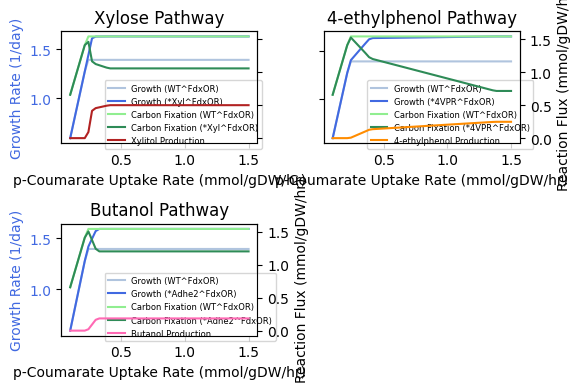

In [29]:
fig

In [34]:
xyl_dtimes

[0.5943429640918323,
 0.7641552395466749,
 0.9339675150014923,
 1.1037797904563207,
 1.2735920659111293,
 1.4434043413659334,
 1.6132166168207809,
 1.630885378311732,
 1.6313119107041931,
 1.6317384430966824,
 1.632164975489145,
 1.632441475164445,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644463,
 1.6324414751644

In [36]:
ep_dtimes

[0.5943429640916659,
 0.764155239546664,
 0.9339675150014622,
 1.1037797904563043,
 1.2735920659111317,
 1.406182735885377,
 1.450049489432727,
 1.493916242979943,
 1.5377829965272536,
 1.581188090091386,
 1.6234930245864583,
 1.6360976584964395,
 1.6366099109222554,
 1.637122163348029,
 1.6376344157738187,
 1.638146668199584,
 1.6386589206253948,
 1.639171173051181,
 1.6396834254769386,
 1.6401956779027365,
 1.640707930328527,
 1.6412201827543114,
 1.641732435180069,
 1.6422446876058832,
 1.6427569400316366,
 1.643269192457435,
 1.6437814448832286,
 1.6442936973089897,
 1.6448059497347842,
 1.6453182021605461,
 1.6458304545863576,
 1.646342707012138,
 1.6468549594379152,
 1.647367211863692,
 1.6478794642895105,
 1.6483917167152664,
 1.6489039691410567,
 1.6494162215668298,
 1.64992847399263,
 1.6504407264184098,
 1.650952978844175,
 1.65146523126998,
 1.6519774836957648,
 1.652489736121558,
 1.6530019885473306,
 1.6533350866146943,
 1.6533350866147167,
 1.6533350866147167,
 1.65333508

In [37]:
but_dtimes

[0.5950390750989727,
 0.7650502394129919,
 0.93506140372697,
 1.105072568040986,
 1.2750837323550055,
 1.4171196740941645,
 1.4929752284252606,
 1.568064642260269,
 1.5892484963339513,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333934,
 1.589248496333